In [3]:
import os
import copy
import functools
import win32com.client

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress, norm
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.fitter import single_siv_ref, two_siv_ref, cavity_ref, three_siv_ref
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [4]:
datafolder_path = win32com.client.Dispatch("WScript.Shell").CreateShortCut("../data.lnk").Targetpath
siv_path = datafolder_path + "/20210903_siv_linescan/"

# List of 2-tuples, first is the avg file (which contains the freq values), second is the scans file
siv_files = [["Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt", "Edown_Ndown/linescan_down_down_low-readingtracescans_18_01_33.txt"],  
             ["Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt", "Edown_Ndown_overnight/linescan_downe_downn_low-readingtracescans_10_37_06.txt"],
             ["Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt", "Edown_Nup/linescan_downe_upn_low-readingtracescans_20_49_33.txt"],
             ["Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt", "Eup_Ndown/linescan_upe_downn_low-readingtracescans_22_45_38.txt"],
             ["Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt", "Eup_Nup/linescan_upe_upn_low-readingtracescans_23_49_04.txt"]
            ]

# Combined Fits + Spectral Diffusion

In [5]:
# Consider using diffusion to blur the output
spectral_diffusion = 0.03

# Sample within 2 stdev
delta_lst = np.linspace(-2*spectral_diffusion, 2*spectral_diffusion, 21)

# Weigh using a normalized Gaussian
normal_pdf = np.array([norm.pdf(delta, 0, spectral_diffusion) for delta in delta_lst])
normal_pdf /= sum(normal_pdf) 

def get_val_from_model(params, scan_idx, model, w):   
    w_c = params[f"w_c"]
    k_in = params["k_in"]
    k_tot = params["k_tot"]
    B = params["B"]
    gamma_up = params[f"gamma_up"]
    
    A = params[f"A_scan{scan_idx}"]
    w_up = params[f"w_up_scan{scan_idx}"]
    g_up = params[f"g_up_scan{scan_idx}"]
    args = [w_up, g_up, gamma_up, w_c, k_in, k_tot, A, B]
    
    # Use diffusion to blur the output
    diffused_output = np.array([model(w + delta, *args) for delta in delta_lst])
    convolved_output = np.sum([diffused_output[i] * normal_pdf[i] for i in range(len(normal_pdf))], axis=0)
    
    return convolved_output
#     return model(w, *args)

def objective(params, freqs_lst, data_lst, model_list):
    residuals_lst = np.array([])
    
    for scan_idx in range(len(data_lst)):
        
        freqs = freqs_lst[scan_idx]
        data = data_lst[scan_idx]
        model = model_list[scan_idx]

        residual = data - get_val_from_model(params, scan_idx, model, freqs)
        residuals_lst = np.append(residuals_lst, residual)

    return residuals_lst

def collect_folder_data(folder_idx):

    siv_freqs = np.loadtxt(siv_path + siv_files[folder_idx][0])
    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
    siv_intensity = np.loadtxt(siv_path + siv_files[folder_idx][1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    return siv_freqs, siv_intensity_avg

def fit_combined_data(fit_params, objective, model_list, w_up_guesses):
            
    siv_freqs_list = []
    siv_data_list = []

    for scan_idx in range(len(siv_files)):
        
        siv_freqs, siv_data = collect_folder_data(scan_idx)
        siv_freqs_list.append(siv_freqs)
        siv_data_list.append(siv_data)
        
        w_up_guess = w_up_guesses[scan_idx]
        fit_params.add(f"w_up_scan{scan_idx}", value=w_up_guess, min=w_up_guess-1, max=w_up_guess+1)
        fit_params.add(f"g_up_scan{scan_idx}", value=5.6, min=1, max=20)
        fit_params.add(f"A_scan{scan_idx}", value=10, min=1, max=20)

    out = lmfit.minimize(objective, fit_params, args=(siv_freqs_list, siv_data_list, model_list), method="lbfgsb")
    return out

# FIt all SiVs with varying k_tot

In [6]:
fit_params = Parameters()
fit_params.add("w_c", value=610, vary=False)#min=0, max=800)
fit_params.add("gamma_up", value=0.05, vary=False)
fit_params.add('k_in', value=99, min=10, max=356)
fit_params.add("k_tot", value=130, min=10, max=356)
fit_params.add("B", value=0, vary=False)

model_list = [single_siv_ref] * len(siv_files)
w_up_guesses = [678.529, 678.489, 678.532, 679.053, 679.031]

combined_results_vary_ktot = fit_combined_data(fit_params, objective, model_list, w_up_guesses)
lmfit.report_fit(combined_results_vary_ktot)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 5184
    # data points      = 800
    # variables        = 17
    chi-square         = 79.3208734
    reduced chi-square = 0.10130380
    Akaike info crit   = -1814.88833
    Bayesian info crit = -1735.24993
[[Variables]]
    w_c:         610 (fixed)
    gamma_up:    0.05 (fixed)
    k_in:        31.1523726 +/- 0.94224183 (3.02%) (init = 99)
    k_tot:       54.5764432 +/- 1.06985407 (1.96%) (init = 130)
    B:           0 (fixed)
    w_up_scan0:  678.505518 +/- 0.00393002 (0.00%) (init = 678.529)
    g_up_scan0:  2.99084277 +/- 0.04335109 (1.45%) (init = 5.6)
    A_scan0:     13.2209138 +/- 0.16799694 (1.27%) (init = 10)
    w_up_scan1:  678.476965 +/- 0.00308398 (0.00%) (init = 678.489)
    g_up_scan1:  2.89203731 +/- 0.03446788 (1.19%) (init = 5.6)
    A_scan1:     17.7380392 +/- 0.21470104 (1.21%) (init = 10)
    w_up_scan2:  678.528640 +/- 0.00388195 (0.00%) (init = 678.532)
    g_up_scan2:  3.08652889 +

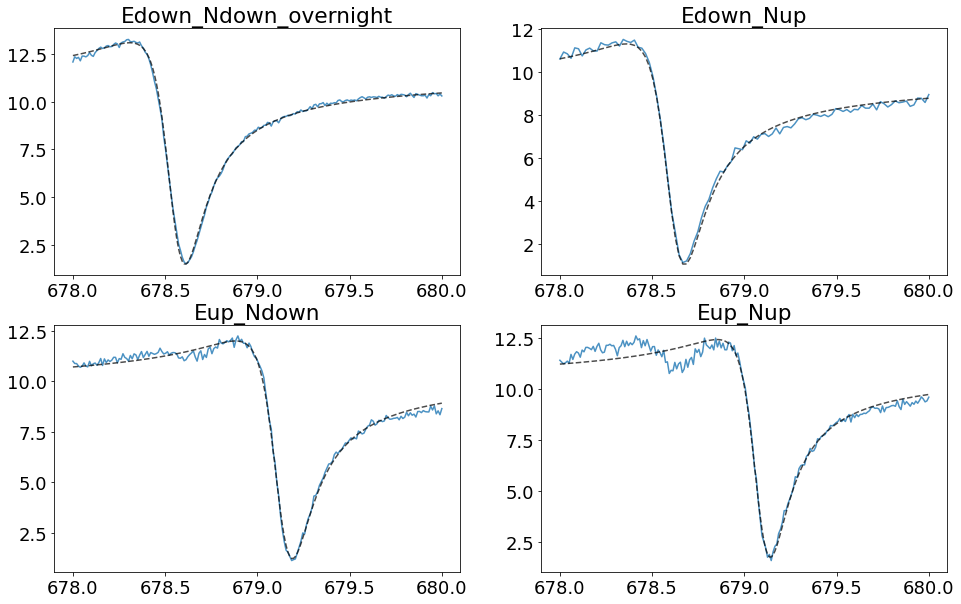

In [7]:
fig, ax = plt.subplots(figsize=[16, 10], ncols=2, nrows=2)
ax = ax.flatten()

# Ignore the first scan as it was shorter
for scan_idx, filename in enumerate(siv_files):
        if scan_idx == 0: continue    

        siv_freqs, siv_data = collect_folder_data(scan_idx)
        ax[scan_idx-1].plot(siv_freqs, siv_data, alpha=0.8)
        ax[scan_idx-1].plot(siv_freqs, get_val_from_model(combined_results_vary_ktot.params, scan_idx, 
                                           model_list[scan_idx], siv_freqs), c='k', ls='--', alpha=0.7)
        ax[scan_idx-1].set_title(filename[0].split("/")[0])

# Compute Phase difference

In [32]:
# Construct Cavity objects from the fitted parameters
cavity_objects = []

for index in range(1, 5):
    c = Cavity({"w_c" : combined_results_vary_ktot.params["w_c"], 
                "k_in" : combined_results_vary_ktot.params["k_in"], 
                "k_tot" : combined_results_vary_ktot.params["k_tot"]}, 
               {"w_up" : combined_results_vary_ktot.params[f"w_up_scan{index}"], 
                "g_up" :combined_results_vary_ktot.params[f"g_up_scan{index}"], 
                "gamma_up" : combined_results_vary_ktot.params["gamma_up"]})
    
    cavity_objects.append(c)

Text(0.5, 0, 'Frequency / GHz')

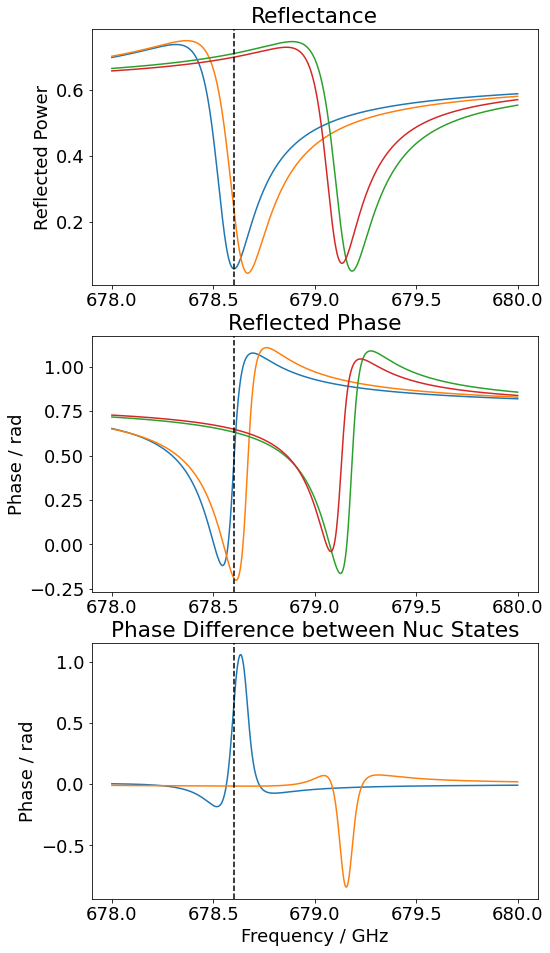

In [35]:
w_arr = np.linspace(678, 680, 1000)
fig, ax = plt.subplots(nrows=3, figsize=[8, 16])
ax = ax.flatten()

# Plot reflectance and reflected phase for 4 states
for c in cavity_objects:
    ax[0].plot(w_arr, c.reflectance(w_arr, 1))
    ax[1].plot(w_arr, c.reflected_phase(w_arr, 1))
    
# Plot difference in phase between each pair of nuclear states
ax[2].plot(w_arr, cavity_objects[0].reflected_phase(w_arr, 1) - cavity_objects[1].reflected_phase(w_arr, 1))
ax[2].plot(w_arr, cavity_objects[2].reflected_phase(w_arr, 1) - cavity_objects[3].reflected_phase(w_arr, 1))

laser_freq = 678.6
for ax_idx in range(3):
    ax[ax_idx].axvline(laser_freq, c='k', ls='--')

ax[0].set_title("Reflectance")
ax[1].set_title("Reflected Phase")
ax[2].set_title("Phase Difference between Nuc States")
ax[0].set_ylabel("Reflected Power")
ax[1].set_ylabel("Phase / rad")
ax[2].set_ylabel("Phase / rad")
ax[2].set_xlabel("Frequency / GHz")

# Test Detuning

## Repeat above plot but shift the cavity position

In [18]:
cavity_objects_copy[0].qubit_params

{'w_down': 15,
 'g_down': 5.6,
 'gamma_down': 0.1,
 'w_up': <Parameter 'w_up_scan1', value=678.4769652393143 +/- 0.00308, bounds=[677.489:679.489]>,
 'g_up': <Parameter 'g_up_scan1', value=2.8920373144919846 +/- 0.0345, bounds=[1:20]>,
 'gamma_up': <Parameter 'gamma_up', value=0.05 (fixed), bounds=[-inf:inf]>}

Phase difference per photon is 0.611 rad


Text(0.5, 0, 'Frequency / GHz')

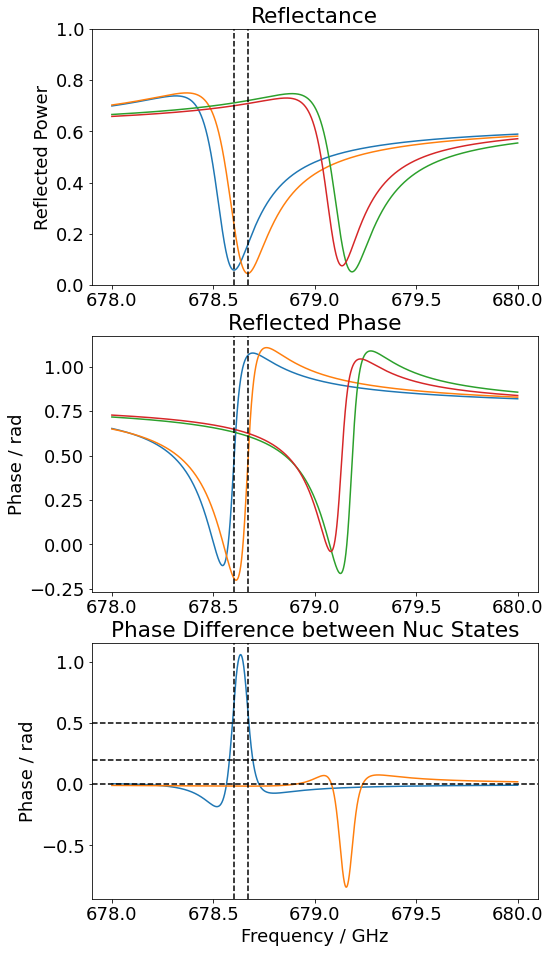

In [90]:
w_arr = np.linspace(678, 680, 120000)
# w_arr = np.linspace(678, 685, 120000)
fig, ax = plt.subplots(nrows=3, figsize=[8, 16])
ax = ax.flatten()

cavity_objects_copy = [copy.deepcopy(c) for c in cavity_objects]

for c in cavity_objects_copy:
    c.cavity_params["w_c"].value = 610
#     c.qubit_params["g_up"].value = 20
    
    # Tweak with cavity kappas
#     c.cavity_params["k_tot"].value = 120
#     c.cavity_params["k_in"].value = 0.57 * c.cavity_params["k_tot"].value
    pass

# Plot reflectance and reflected phase for 4 states
for c in cavity_objects_copy:
    ax[0].plot(w_arr, c.reflectance(w_arr, 1))
    ax[1].plot(w_arr, np.unwrap(c.reflected_phase(w_arr, 1)))
    
# Plot difference in phase between each pair of nuclear states
phase_diff_01 = np.unwrap(cavity_objects_copy[0].reflected_phase(w_arr, 1) - cavity_objects_copy[1].reflected_phase(w_arr, 1))
phase_diff_23 = np.unwrap(cavity_objects_copy[2].reflected_phase(w_arr, 1) - cavity_objects_copy[3].reflected_phase(w_arr, 1))
ax[2].plot(w_arr, phase_diff_01)
ax[2].plot(w_arr, phase_diff_23)

# Park laser at the min of the dip of state 00
laser_freq_idx = np.argmin(cavity_objects_copy[0].reflectance(w_arr, 1))
laser_freq = w_arr[laser_freq_idx]
for ax_idx in range(3):
    ax[ax_idx].axvline(laser_freq, c='k', ls='--')
# Park laser at the min of the dip of state 01
laser_freq_idx = np.argmin(cavity_objects_copy[1].reflectance(w_arr, 1))
laser_freq = w_arr[laser_freq_idx]
for ax_idx in range(3):
    ax[ax_idx].axvline(laser_freq, c='k', ls='--')
    
ax[2].axhline(0., c='k', ls='--')
ax[2].axhline(0.2, c='k', ls='--')
ax[2].axhline(0.5, c='k', ls='--')
print(f"Phase difference per photon is {phase_diff_01[laser_freq_idx]:.3f} rad")

ax[0].set_ylim(0, 1)
ax[0].set_title("Reflectance")
ax[1].set_title("Reflected Phase")
ax[2].set_title("Phase Difference between Nuc States")
ax[0].set_ylabel("Reflected Power")
ax[1].set_ylabel("Phase / rad")
ax[2].set_ylabel("Phase / rad")
ax[2].set_xlabel("Frequency / GHz")

### Plot nuclear phase difference for various detunings

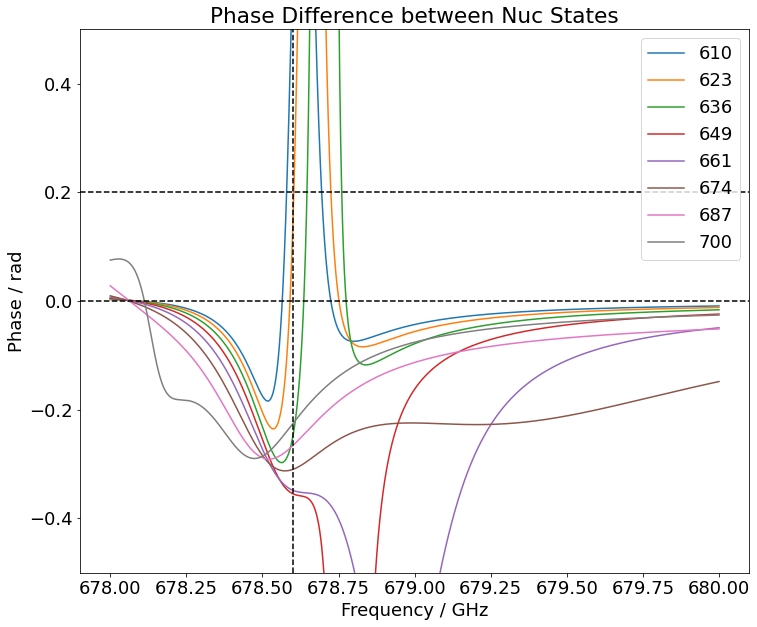

In [180]:
w_arr = np.linspace(678, 680, 12000)
cavity_pos_arr = np.linspace(610, 700, 8)
cavity_objects_copy = [copy.deepcopy(c) for c in cavity_objects]

plt.figure(figsize=[12, 10])

for cavity_pos in cavity_pos_arr:
    for c in cavity_objects_copy:
        c.cavity_params["w_c"].value = cavity_pos

    # Plot difference in phase between each pair of nuclear states
    phase_diff_01 = np.unwrap(cavity_objects_copy[0].reflected_phase(w_arr, 1) - cavity_objects_copy[1].reflected_phase(w_arr, 1))
    plt.plot(w_arr, phase_diff_01, label=f"{cavity_pos:.0f}")

plt.title("Phase Difference between Nuc States")
plt.ylabel("Phase / rad")
plt.xlabel("Frequency / GHz")
plt.ylim(-.5, .5)
plt.axvline(678.6, c='k', ls='--')
plt.axhline(0, c='k', ls='--')
plt.axhline(0.2, c='k', ls='--')
plt.legend()

## Iterate over cavity position, find the phase at dip min

Text(0, 0.5, 'Reflectivity / Phase')

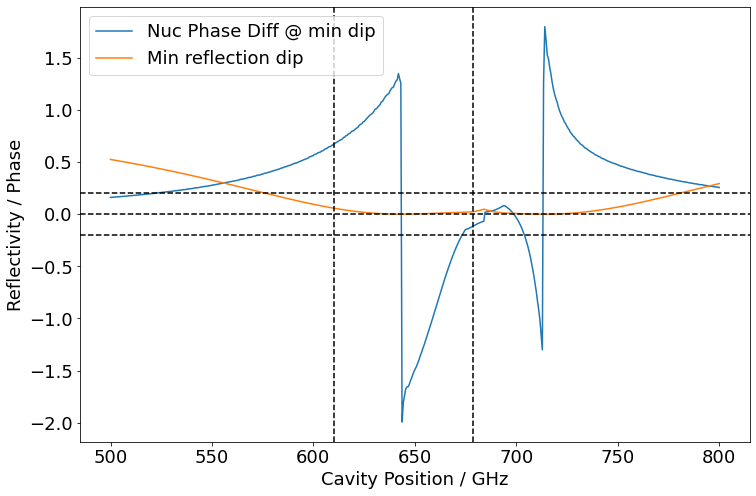

In [11]:
cavity_pos_arr = np.linspace(500, 800, 500)
w_arr = np.linspace(678, 680, 6000)
phase_diff = []
min_refs = []
plt.figure(figsize=[12, 8])

for cavity_pos in cavity_pos_arr:
    cavity_objects_copy = [copy.deepcopy(c) for c in cavity_objects]
    
    # Change all cavity positions
    for c in cavity_objects_copy:
        c.cavity_params["w_c"].value = cavity_pos
        
        # Tweak to use the "real" kappas
#         c.cavity_params["k_tot"].value = 200
#         c.cavity_params["k_in"].value = 0.57 * c.cavity_params["k_tot"].value

    # Difference in phase between each pair of nuclear states
    phase_diff_01 = (cavity_objects_copy[0].reflected_phase(w_arr, 1) - cavity_objects_copy[1].reflected_phase(w_arr, 1))

    # Park laser at the min of the dip of state 00
    laser_freq_idx = np.argmin(cavity_objects_copy[0].reflectance(w_arr, 1))
    min_ref = np.min(cavity_objects_copy[0].reflectance(w_arr, 1))
    min_refs.append(min_ref)

    # Phase difference per photon at laser position
    phase_diff.append(phase_diff_01[laser_freq_idx])
    
    
phase_diff = np.mod(phase_diff, 2*np.pi)
phase_diff[phase_diff > np.pi] -= 2*np.pi

plt.plot(cavity_pos_arr, phase_diff, label="Nuc Phase Diff @ min dip")
plt.plot(cavity_pos_arr, min_refs, label="Min reflection dip")
# plt.ylim(-0.4, 0.4)
plt.axvline(610, c='k', ls='--')
plt.axvline(678.6, c='k', ls='--')
plt.axhline(0., c='k', ls='--')
plt.axhline(0.2, c='k', ls='--')
plt.axhline(-0.2, c='k', ls='--')
plt.legend()
plt.xlabel("Cavity Position / GHz")
plt.ylabel("Reflectivity / Phase")

# Looks weird for cavity at 645, let's check the plots

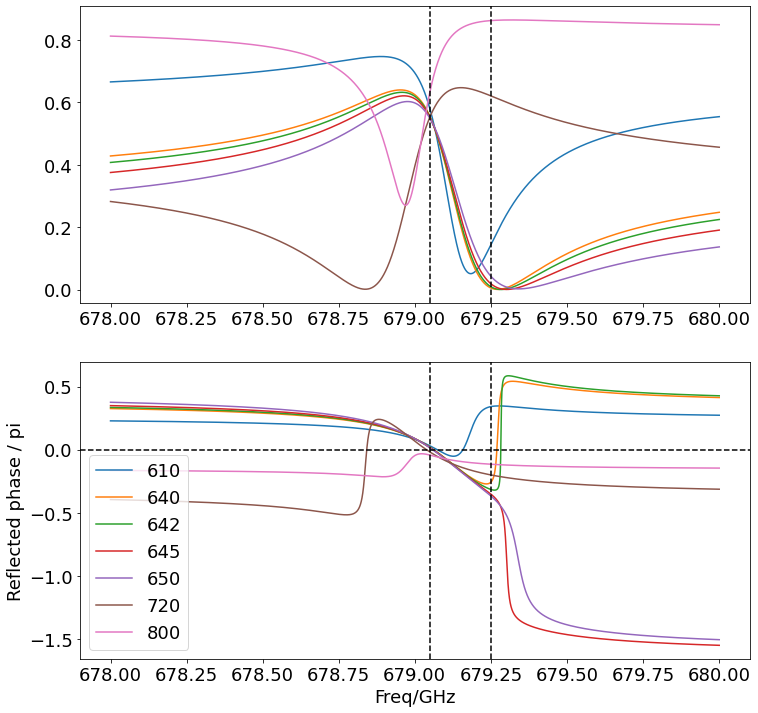

In [81]:
w_arr = np.linspace(678, 680, 12000)
fig, ax = plt.subplots(nrows=2, figsize=[12, 12])
ax = ax.flatten()

ax[0].plot(w_arr, (cavity_objects[2].reflectance(w_arr, 1)), 
         label=cavity_objects[2].cavity_params["w_c"].value)

ax[1].plot(w_arr, (cavity_objects[2].reflected_phase(w_arr, 1)) / np.pi, 
         label=cavity_objects[2].cavity_params["w_c"].value)

for wc_val in [640, 642, 645, 650, 720, 800]:#, 660, 670, 680, 700, 720]:
    
    c2_copy = copy.deepcopy(cavity_objects[2])
    c2_copy.cavity_params["w_c"].value = wc_val
#     c2_copy.cavity_params["k_in"].value = 20

    # Plot reflectance and reflected phase for 4 states
    phase = np.unwrap(c2_copy.reflected_phase(w_arr, 1)) / np.pi
    if phase[0] < -0.5:
        phase += 2
    
    ax[0].plot(w_arr, c2_copy.reflectance(w_arr, 1), label=wc_val)
    ax[1].plot(w_arr, phase, label=wc_val)
    
plt.ylabel("Reflected phase / pi")
plt.xlabel("Freq/GHz")
ax[0].axvline(c2_copy.qubit_params["w_up"].value, c="k", ls="--")
ax[0].axvline(679.25, c="k", ls="--")
ax[1].axvline(679.25, c="k", ls="--")
ax[1].axhline(0, c="k", ls="--")
ax[1].axvline(c2_copy.qubit_params["w_up"].value, c="k", ls="--")
plt.legend()
# ax[1].set_ylim(-0.4 ,-0.3)
# ax[1].set_xlim(679.1 ,679.3)

### Complex reflection coeff as a function of cavity pos and frequency

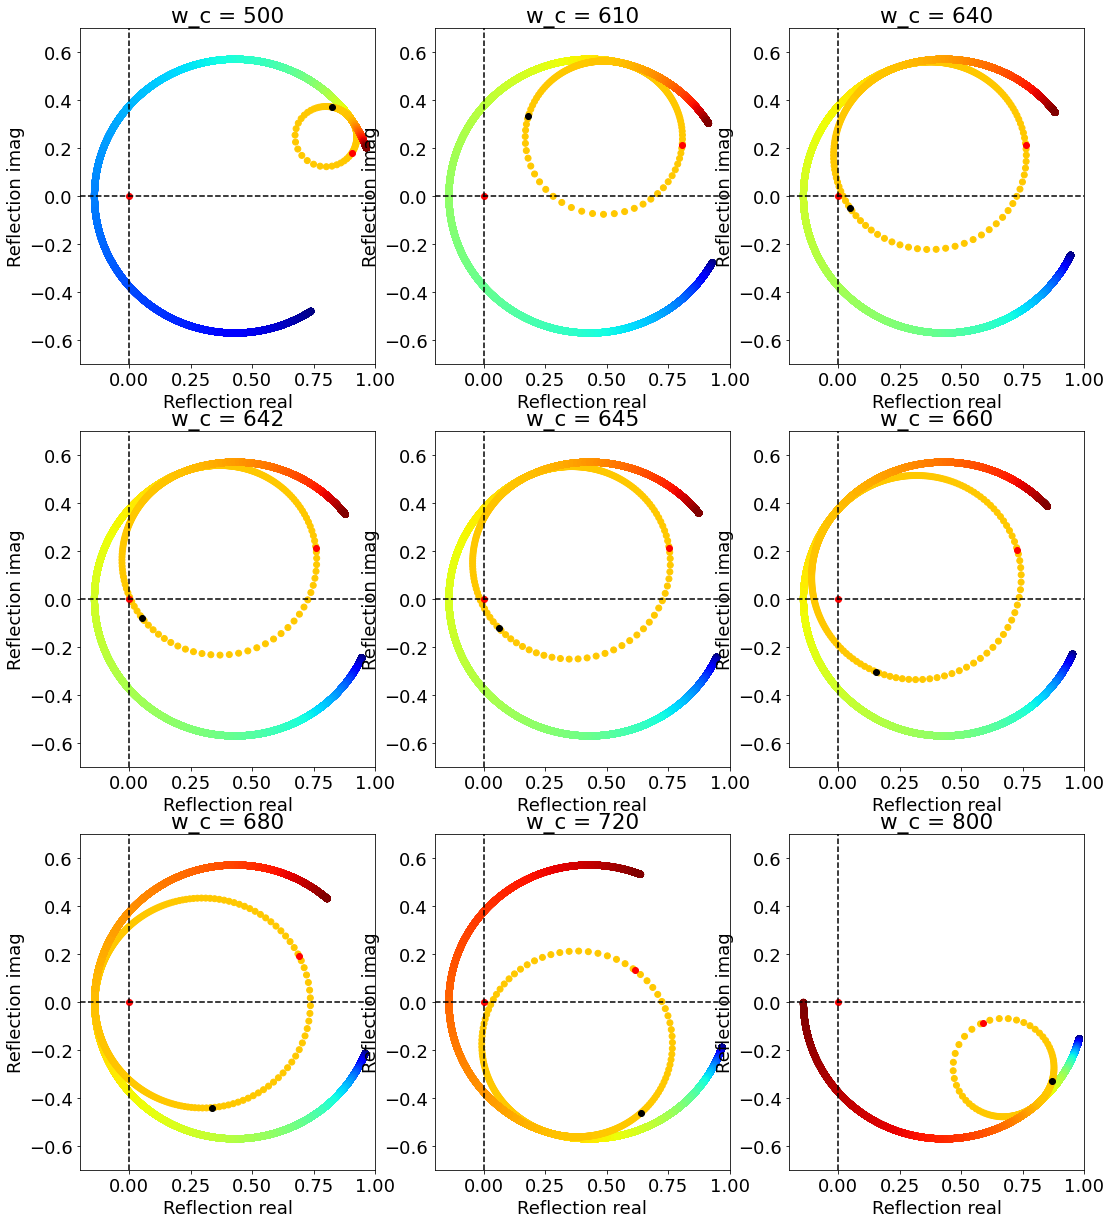

In [80]:
# w_arr = np.append(np.linspace(400, 678.5, 5000), np.linspace(679.5, 900, 5000))
# w_arr_fine = np.linspace(678.5, 679.5, 1000)
w_arr = np.linspace(400, 800, 50000)

wc_arr = [500, 610, 640, 642, 645, 660, 680, 720, 800]
cm = plt.cm.get_cmap('jet')

fig, ax = plt.subplots(ncols=3, nrows=len(wc_arr)//3, figsize=[18, 7*len(wc_arr)//3])
ax = ax.flatten()

for idx, wc_val in enumerate(wc_arr):    
    c2_copy = copy.deepcopy(cavity_objects[2])
    c2_copy.cavity_params["w_c"].value = wc_val
#     c2_copy.cavity_params["k_in"].value = 20
    
    # Kill qubit
#     c2_copy.qubit_params["g_up"].min = 0
#     c2_copy.qubit_params["g_up"].value = 0

    r = c2_copy.complex_reflect_coeff_fn(w_arr, 1, [c2_copy.qubit_params], **c2_copy.cavity_params)
#     r_fine = c2_copy.complex_reflect_coeff_fn(w_arr_fine, 1, [c2_copy.qubit_params], **c2_copy.cavity_params)
    pt = c2_copy.complex_reflect_coeff_fn(679.25, 1, [c2_copy.qubit_params], **c2_copy.cavity_params)
    pt2 = c2_copy.complex_reflect_coeff_fn(679, 1, [c2_copy.qubit_params], **c2_copy.cavity_params)
    
    ax[idx].scatter(r.real, r.imag, c=range(len(r.real)), cmap=cm)
#     ax[idx].scatter(r_fine.real, r_fine.imag, c=range(len(r_fine.real)), cmap=cm)
    
    ax[idx].scatter(pt.real, pt.imag, c='k')
    ax[idx].scatter(pt2.real, pt2.imag, c='r')
    
    ax[idx].scatter([0], [0], c='r')
    ax[idx].axhline(0, c='k', ls='--')
    ax[idx].axvline(0, c='k', ls='--')
    
    ax[idx].set_title(f"w_c = {wc_val}")
    ax[idx].set_xlabel("Reflection real")
    ax[idx].set_ylabel("Reflection imag")
    
    ax[idx].set_xlim(-0.2 ,1)
    ax[idx].set_ylim(-0.7, 0.7)

### Compute by hand

In [82]:
# Print out the cavity parameters and predicted phase

def try_value(v):
    try:
        return v.value
    except AttributeError:
        return v

c2_copy = copy.deepcopy(cavity_objects[2])
print({k: try_value(v) for k, v in c2_copy.qubit_params.items()})
print({k: try_value(v) for k, v in c2_copy.cavity_params.items()})

# w_up = c2_copy.qubit_params["w_up"].value
# print(w_up)

print(c2_copy.reflected_phase(679.25, 1))

{'w_down': 15, 'g_down': 5.6, 'gamma_down': 0.1, 'w_up': 679.0499957913462, 'g_up': 3.0102486245123785, 'gamma_up': 0.05}
{'w_c': 610, 'k_in': 31.152959856312933, 'k_out': 0, 'k_tot': 54.577356198412616}
1.0737912080270002


In [83]:
# Compute by hand

np.angle(1 - 2*31.153*(1j*(679.25-679.05)+0.05) / ( (1j*(679.25-610)+54.577) * (1j*(679.25-679.05)+0.05) + 3.010**2  ))

1.0737914314327537

In [75]:
params = {"w_up": w_up, "g_up": 3.01023, "gamma_up": 0.05}
w_c = 610
k_in = 31.15237
k_tot = 54.5766
w = 679.25

denom = 1j * (w - w_c) + k_tot 
denom += params["g_up"] ** 2 / (1j * (w - params["w_up"]) + params["gamma_up"])
r = 1 - (2 * k_in / denom)
print(r)
print(r * np.conjugate(r))
print(np.arctan2(r.imag, r.real))
print(np.angle(r)) 

(0.18116748498908963+0.333982221736208j)
(0.1443657820531256+0j)
1.0737708439796163
1.0737708439796163
